# CLUSTER-DATA-SPLIT

### Reference
This tool implements the methods described in the paper following paper.

> Hanna Wecker, Annemarie Friedrich, and Heike Adel.
*ClusterDataSplit: Evaluation Challenging Data Splits for Model Performance Evaluation*. In Proceedings of Eval4NLP 2020.

If you use this tool, please cite the above paper.


### LICENSE info
ClusterDataSplit is open-sourced under the AGPL-3.0 license. See the LICENSE file at the top level of this project for details. For a list of other open source components included in ClusterDataSplit, see the file 3rd-party-licenses.txt at the top level of this project.

# (3) Analyzing Performance w.r.t. to Data Split Characteristics

Welcome to the performance analysis notebook! This notebook enables you to explore the performance of your models trained in a cross-validation setting dependent on the underlying data splits.

## Conda environment
To ensure that all packages can be loaded, run this notebook in the environment specified by the file `clusterdatasplit.yml`.

In [1]:
import sklearn
print(sklearn.__version__)
version_nr = int(sklearn.__version__.split(".")[1])
if version_nr > 23:
    print("Careful - ClusterDataSplit only works with sklearn <= version 0.23 !!")

0.23.1


In [2]:
# load packages
import matplotlib
import seaborn as sns
import pickle as pkl
import pandas as pd
from utils import *
import ipywidgets as widgets
from IPython.display import display

In [3]:
# Options for Figures
sns.set(style = 'whitegrid', font = 'sans-serif', font_scale=1)
sns.set_palette("hls", 5)
matplotlib.rcParams['figure.figsize'] = (10, 7.5)

Throughout this notebook, you can choose to either explore the output of your experiment only, or the output of the experiment with some reference to a benchmark. If you would like to use a benchmark, please set the following variable to True.

In [4]:
include_benchmark = True

### Load Input Data

In [17]:
# Path to folder with all files related to the dataset in question
# project_path = os.path.join(os.getcwd(), "data/patent_classification") # multi-class classification example
project_path = os.path.join(os.getcwd(), "data/toy_data") # binary classification toy example

This notebook requires the following input files: <br>

* In the following, `dataSplitInfo` refers to the algorithm used to generate the respective data splits.
* The file `analysis_dataSplitInfo.tsv` (or similar filename) generated by the previous notebook in the ClusterDataSplit Series. <br>
* The raw input data with the columns (gold) `labels` and `text_input_data` (stored as `input_data.tsv`).
* In a file called `predictions_dataSplitInfo.tsv`: the predictions generated by the models stored in a dictionary. Here, the key describes the data split the model was evaluated on and the values are a list with the matching predictions.

Please include the paths to the different files below. If you selected not to include a benchmark, your entries in the respective fields will be ignored. Please also specify which kind of data splits (for example, size and distribution sensitive or randomized data splits) you are entering.

In [18]:
# Note: predictions files are currently dummies here!

algorithm = "distribution_sensitive_kmeans"
# info which datapoint belongs to which split, including gold labels
data_split_info = pd.read_csv(os.path.join(project_path, "analysis_" + algorithm + ".tsv"), sep = "\t")
# original text of instances
input_data = pd.read_csv(os.path.join(project_path, 'input_data.tsv'), delimiter = "\t")

# add column for predictions
data_split_info["predictions"] = [None for x in range(len(data_split_info))]
                                        
predictions = read_predictions(os.path.join(project_path, "predictions_" + algorithm + ".tsv"), data_split_info)

if include_benchmark:
    benchmark_datasplit = "randomized"
    benchmark_data_split_info = pd.read_csv(os.path.join(project_path, "analysis_" + benchmark_datasplit + ".tsv"), sep = "\t")
    benchmark_input_data = pd.read_csv(os.path.join(project_path, 'input_data.tsv'), delimiter = "\t")
    #with open(os.getcwd() + '/patent_classification/predictions_patents_randomized.pickle', 'rb') as predictions_file:
    #    benchmark_predictions = pkl.load(predictions_file) 
    benchmark_predictions = read_predictions(os.path.join(project_path, "predictions_" + benchmark_datasplit + ".tsv"), benchmark_data_split_info)
    

In [19]:
# Change labels to integer coding
labelset = np.unique(input_data["labels"]) # determine label set
label2idx = {l: i for i, l in enumerate(labelset)}
idx2label = {label2idx[l] : l for l in label2idx}
data_split_info["gold_labels"].replace(label2idx, inplace=True)
data_split_info["predictions"].replace(label2idx, inplace=True)

if include_benchmark:
    # simply assuming same label set
    benchmark_data_split_info["gold_labels"].replace(label2idx, inplace=True)
    benchmark_data_split_info["predictions"].replace(label2idx, inplace=True)

In [20]:
data_split_info, cluster_ids = process_inputs(input_data, data_split_info)

if include_benchmark:
    benchmark_data_split_info, benchmark_cluster_ids = process_inputs(benchmark_input_data, benchmark_data_split_info)


## Performance & Cluster Characteristics

In the table describing the performances of the experiment(s), the columns contain the cluster ID the model was evaluated on. For example, the model performance summarized under "1" was attained by the model trained on the cross-validation folds 2-5 (in a five-fold CV) and evaluated on fold 1. The columns 'mean' and 'std' contain the mean performance and the performance standard deviation. The plots visualize the clusters, the relative size of the clusters, the label distribution within the clusters and the mean sentence lengths for the different clusters.

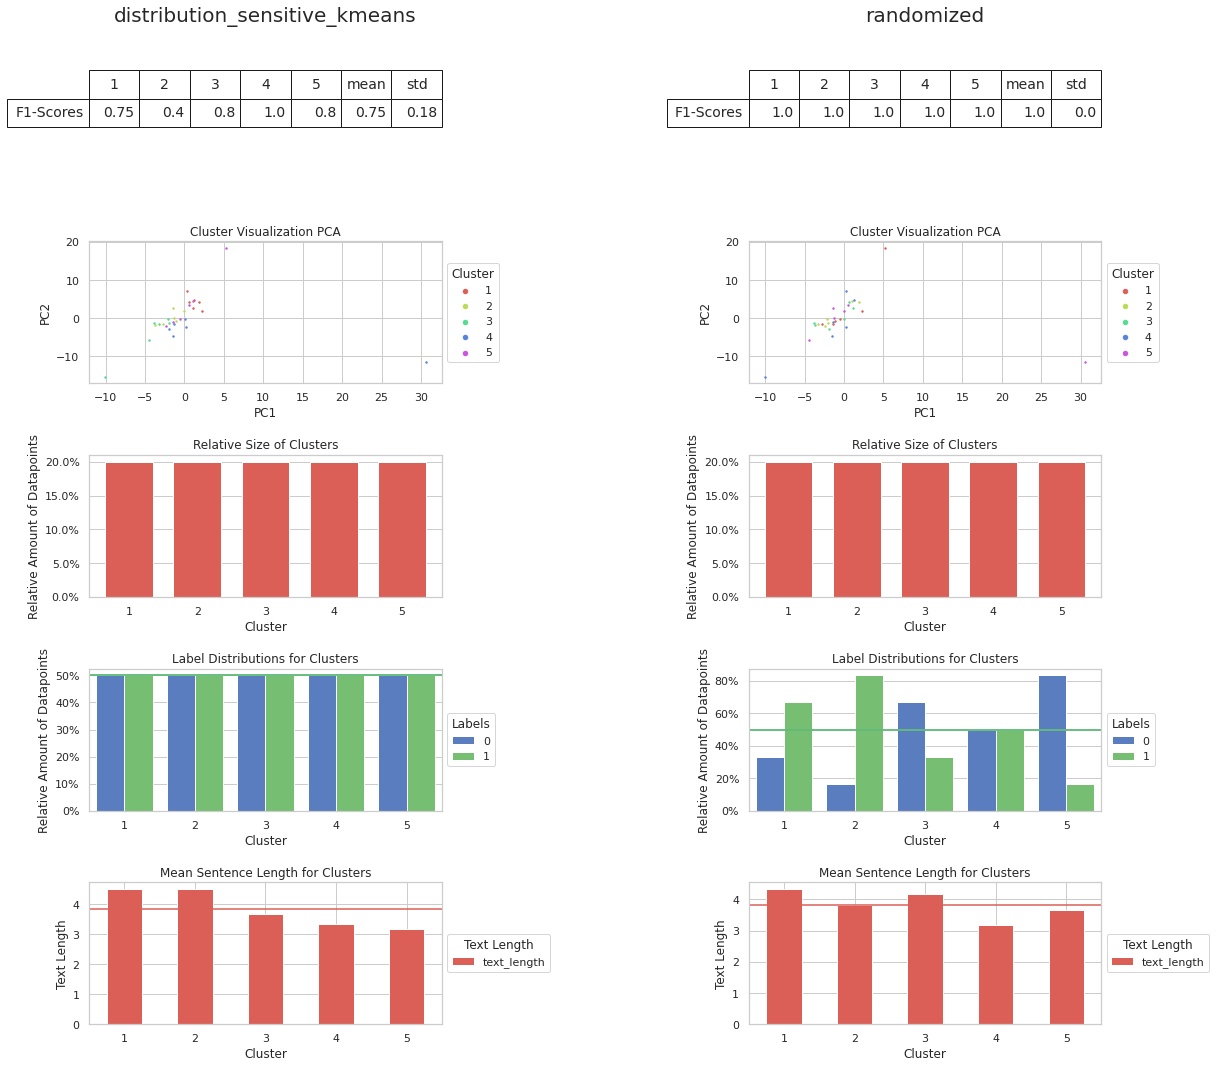

In [21]:
binary_task = len(labelset) == 2

if include_benchmark:
    generate_plots(binary_task, algorithm, data_split_info, cluster_ids, include_benchmark, benchmark_datasplit, benchmark_data_split_info, benchmark_cluster_ids)
else:
    generate_plots(binary_task, algorithm, data_split_info, cluster_ids, include_benchmark)

### Example Text From Clusters

In [22]:
display_cluster = widgets.Dropdown(
    options = cluster_ids,
    description = 'Cluster')

display(display_cluster)

Dropdown(description='Cluster', options=(1, 2, 3, 4, 5), value=1)

------------------------------Cluster 1 ------------------------------------


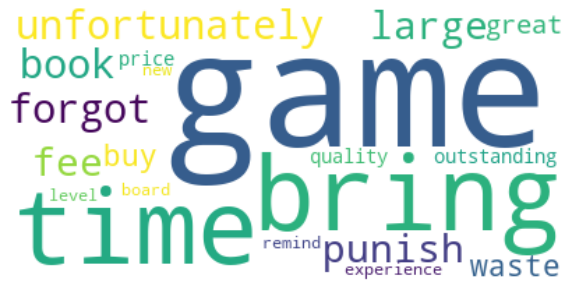

In [23]:
cluster_data_index = np.where(data_split_info['clustering_labels'] == display_cluster.value)[0]
cluster_text = ' '.join(input_data.iloc[cluster_data_index, 2])
print('------------------------------Cluster {} ------------------------------------'.format(display_cluster.value))
generate_wordcloud(cluster_text, 20)